In [277]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load Data
Create a folder in the root folder named data and put the appropriate excel files in there
.gitignore will prevent it from the data being pushed to the git repo 

In [255]:
df = pd.read_excel('data/Report_21_050718_3.xls')

In [256]:
df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

In [257]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [261]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)

### Join onto demographics

In [262]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

### Normalizing Numeric Columns
We probably have to do this by demographics as well, but just keeping this here for framework

In [263]:
numeric_cols = out.loc[:,out.dtypes =='float64']
numeric_cols = (numeric_cols-numeric_cols.mean())/numeric_cols.std()
non_numeric_cols = out.loc[:,~(out.dtypes =='float64')]
out = pd.concat([numeric_cols,non_numeric_cols], axis=1)

### PCA, Exploratory Stuff

In [283]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(numeric_cols)  
print(pca.explained_variance_ratio_)

[0.61470456 0.0548033 ]


In [273]:
print(pca.singular_values_)  

[222.17423512  66.33822516]


In [284]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [294]:
finalDf = pd.concat([principalDf, out['group']], axis = 1, ignore_index=True)

ValueError: Shape of passed values is (216, 3), indices imply (144, 3)

KeyError: 'principal component 1'

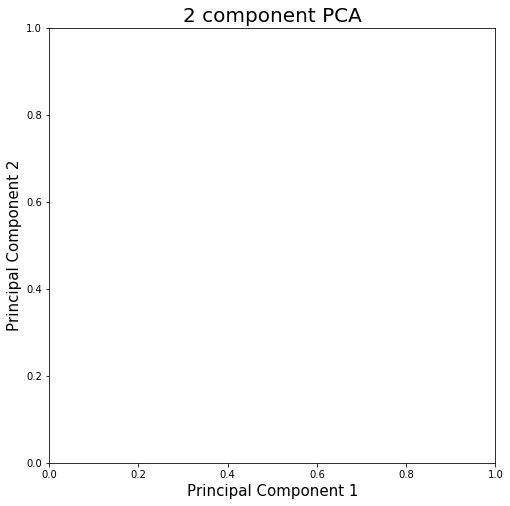

In [285]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['c','a','m']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = out['group'] == target
    ax.scatter(out.loc[indicesToKeep, 'principal component 1']
               , out.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()